In [17]:
import numpy as np
import matplotlib.pyplot as plt

### Задача 6.1.10

In [18]:
def mnk(x_arr, y_arr, m):
    """
    Находит полином m-ой степени по МНК.

    :return np.ndarray: коэффициенты полинома.
    """
    assert x_arr.ndim == 1
    assert y_arr.ndim == 1
    
    G = np.zeros((m + 1, m + 1))
    b = np.zeros(m + 1)

    for i in range(m + 1):
        b[i] = np.dot(x_arr ** i, y_arr)
        for j in range(m + 1):
            G[i, j] = np.sum(x_arr ** (i + j))
            
    return np.linalg.solve(G, b)


def sigma_rate(poly_w, x_arr, y_arr):
    """
    Находит сигму для полинома.
    """
    assert poly_w.ndim == 1
    assert y_arr.ndim == 1
    
    m = poly_w.size - 1
    n = y_arr.size - 1

    X_mat = np.stack([x_arr ** k for k in range(m + 1)])
    X_mat = X_mat.T
    
    y_pred = np.dot(X_mat, poly_w)
    
    error = np.sum((y_pred - y_arr) ** 2)
    error /= (n - m)
    return np.sqrt(error)


def approx_poly(x_arr, y_arr, m_max=None, show=True, save=False, fname=None):
    """
    Строит аппроксимационные полиномы и показывает значения сигмы для
    каждого из них.
    """
    n = x_arr.size - 1
    if m_max is None:
        m_max = n - 1

    poly_weights = {}
    poly_sigmas = {}

    for m in range(m_max + 1):
        poly_w = mnk(x_arr, y_arr, m)
        sigma = sigma_rate(poly_w, x_arr, y_arr)
        poly_weights[m] = poly_w
        poly_sigmas[m] = sigma

    if show:
        plt.bar(poly_sigmas.keys(), poly_sigmas.values(), color='magenta')
        plt.xticks(range(m_max + 1))
        plt.xlabel("m")
        plt.ylabel("$\sigma$", rotation=0)
        plt.grid(True)
        if save:
            plt.savefig(fname)
        plt.show()

    return poly_weights

In [19]:
def show_poly(poly_weights, m_max=None, x_min=-3, x_max=3):
    """
    Визуализирует полиномы.
    """
    assert isinstance(poly_weights, dict)
    x_arr = np.linspace(x_min, x_max, 250)
    
    for m, poly_w in poly_weights.items():
        if m_max is not None and m > m_max:
            break
        X_mat = np.stack([x_arr ** k for k in range(m + 1)]).T
        y_arr = np.dot(X_mat, poly_w)

        plt.plot(x_arr, y_arr, label=f'$P_{ {m} }$')

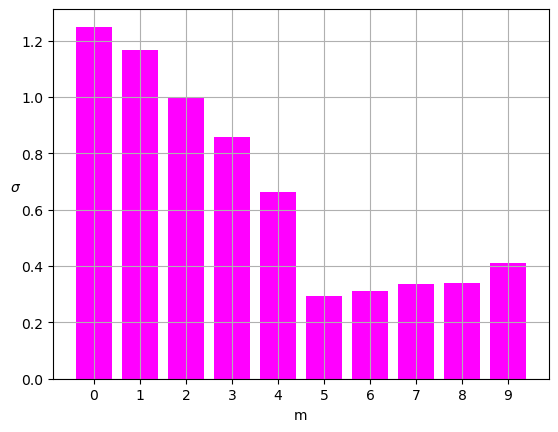

In [20]:
xs = np.array([
    -3.6, -3.08, -2.56, -2.04, -1.52, -1, 
    -0.48, 0.04, 0.56, 1.08, 1.6
])

ys = np.array(
    [-2.397, -0.401, -0.577, -1.268, -0.933, -0.359, 
     1.107, 1.300, 1.703, -0.299, -1.417]
)

poly_w = approx_poly(xs, ys, save=True, fname='plots/task1_hist.png')

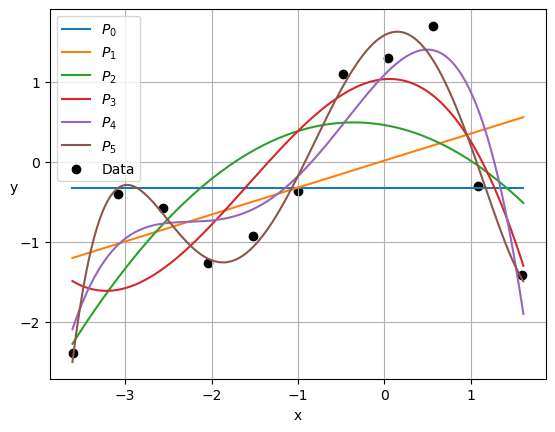

In [21]:
show_poly(poly_w, m_max=5, x_min=xs.min() - 1e-2, x_max=xs.max() + 1e-2)
plt.scatter(xs, ys, c='black', marker='o', label='Data')

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend()

plt.grid(True)
plt.savefig(fname='plots/task1_polynoms.png')
plt.show()

### Задача 6.4.2

In [22]:
def least_squares(x_arr, y_arr, m):
    """
    Находит коэффициенты a и b по МНК.
    """
    pows = [0, m]

    G = np.zeros((2, 2))
    b = np.zeros(2)

    for i, p1 in enumerate(pows):
        b[i] = np.dot(x_arr ** p1, y_arr)
        for j, p2 in enumerate(pows):
            G[i, j] = np.sum(x_arr ** (p1 + p2))
    return np.linalg.solve(G, b)


def get_argument(y_target, m, w):
    """
    Находит значение x по значению y.

    :param y_target: значение y.
    :param m: степень полинома.
    :param w: параметры
    """

    assert w.shape == (2,)
    b, a = w
    return ((y_target - b) / a) ** (1/m) 

In [23]:
m = 2
y_hat = 8

xs = np.array([
    1.5, 2.1, 2.7, 3.3, 3.9, 4.5, 5.1
])

ys = np.array([
    11.1, 10.3, 9.08, 7.64, 5.92, 3.90, 1.60
])

w = least_squares(xs, ys, m)
print(w)

[12.02050691 -0.40092166]


In [24]:
print(get_argument(y_hat, m, w))

3.1667271621565747


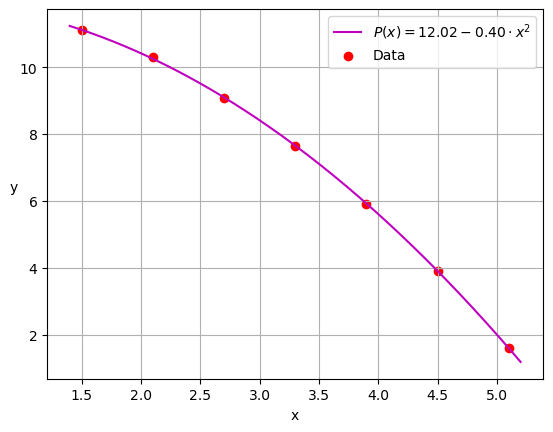

In [25]:
x_list = np.linspace(xs.min() - 1e-1, xs.max() + 1e-1, 250)
y_list = w[0] + w[1] * (x_list ** m)

plt.plot(x_list, y_list, 'm', label=f'$P(x) = {w[0]:.2f} {w[1]:.2f}\cdot x^{m}$')
plt.scatter(xs, ys, marker='o', c='red', label='Data')

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.grid(True)
plt.legend()

plt.savefig(fname='plots/task2-polynomial.png')
plt.show()

### Задача 6.7.5

In [26]:
class LinearInterp1d:
    """
    Класс для линейной интерполяции.
    """
    def __init__(self, x, y):
        assert x.ndim == 1
        assert y.ndim == 1
        assert x.shape == y.shape
        
        self.a = x.min()
        self.b = x.max()
        self.segments = {}

        for i in range(1, x.size):
            x0, x1 = x[i-1], x[i]
            y0, y1 = y[i-1], y[i]
            
            k = (y1 - y0)/ (x1 - x0)
            b = 0.5 * (y0 + y1) - k / 2 * (x0 + x1)

            self.segments[(x0, x1)] = (k, b)

    def __call__(self, x):
        """
        Вычисляет значения функции в точках.
        """
        assert x.ndim == 1
        
        y = np.zeros(x.size)
        for i, x_p in enumerate(x):
            y[i] = self._interp1point(x_p)

        return y

    def _interp1point(self, x_p):
        """
        Вспомогательный метод для нахождения значения функции в точке.
        """
        if x_p < self.a or self.b < x_p:
            raise ValueError(f'x={x_p}, a={self.a}, b={self.b}')

        kx, bx = None, None
        for (x0, x1), (k, b) in self.segments.items():
            if x0 <= x_p and x_p <= x1:
                kx = k
                bx = b
                break
        return k * x_p + b

In [27]:
class NewtonInterp1d:
    """
    Класс для интерполяции с помошью интеполяционного многочлена в форме Ньютона.
    """
    def __init__(self, x, y):
        assert x.ndim == 1
        assert y.ndim == 1
        assert x.shape == y.shape

        n = x.size - 1
        self.n = n
        self.f_coeffs = np.zeros(n + 1)
        self.x_data = x.copy()

        for k in range(n + 1):
            divided_diff = 0.0
            for i in range(k + 1):
                divider = 1
                for j in range(k + 1):
                    if j == i:
                        continue
                    divider *= (self.x_data[i] - self.x_data[j])
                divided_diff += (y[i] / divider)
            self.f_coeffs[k] = divided_diff 
    
    def __call__(self, x):
        """
        Находит значения интерполяционного многочлена в точках. 
        """
        assert x.ndim == 1

        poly_res = 0.0
        term = 1
        for k in range(self.n + 1):
            poly_res += term * self.f_coeffs[k]
            term *= (x - self.x_data[k])
        return poly_res

In [28]:
def f(x):
    return np.abs(x-1) * np.exp(x)

a, b = 0, 2
k = 8  # Выбранное значение

x_part = np.linspace(start=a, stop=b, num=k, endpoint=True)
y_part = f(x_part)

lin_interp = LinearInterp1d(x_part, y_part)
newton_interp = NewtonInterp1d(x_part, y_part)

x_all = np.linspace(start=a, stop=b, num=3*k, endpoint=True)

y_true = f(x_all)
y_lin = lin_interp(x_all)
y_newton = newton_interp(x_all)

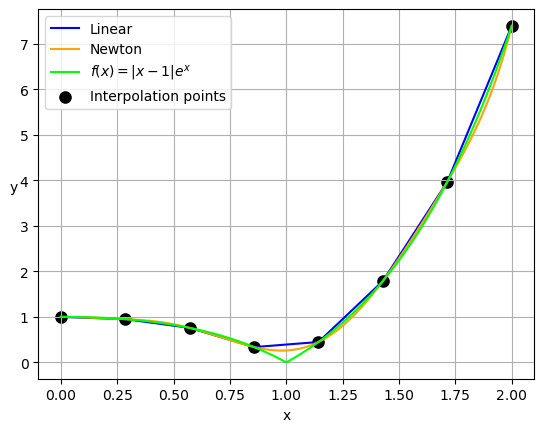

In [29]:
def plot_interp(func, a, b, n_points=250, c=None, label=None):
    x_list = np.linspace(a, b, n_points, endpoint=True)
    y_list = func(x_list)
    plt.plot(x_list, y_list, c=c, label=label)


plot_interp(lin_interp, a, b, c='blue', label='Linear')
plot_interp(newton_interp, a, b, c='orange', label='Newton')
plot_interp(f, a, b, c='lime', label='$f(x)=|x-1|e^x$')
plt.scatter(x_part, y_part, marker='o', c='black', s=65, label='Interpolation points')

plt.xlabel('x')
plt.ylabel('y', rotation=0)

plt.grid(True)
plt.legend()

plt.savefig('plots/task3_intepolations.png')
plt.show()

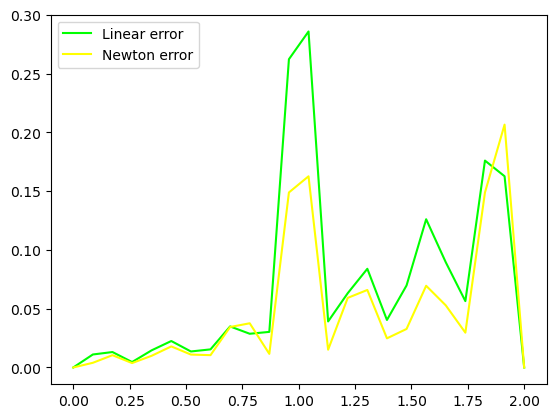

In [30]:
lin_err = np.abs(y_lin - y_true)
newton_err = np.abs(y_newton - y_true)

plt.plot(x_all, lin_err, c='lime', label='Linear error')
plt.plot(x_all, newton_err, c='yellow', label='Newton error')

plt.legend(loc='upper left')
plt.savefig('plots/task3_errors.png')
plt.show()

### Задача 6.9.5

In [31]:
from scipy.interpolate import CubicSpline

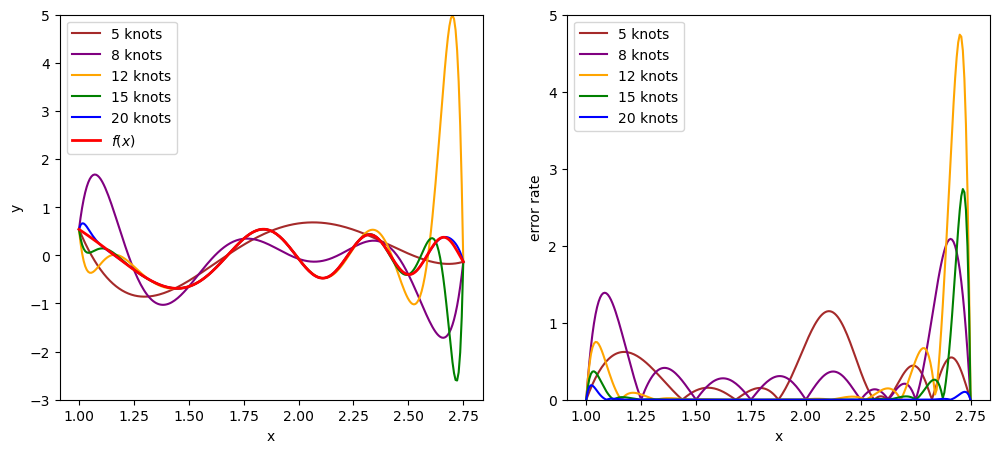

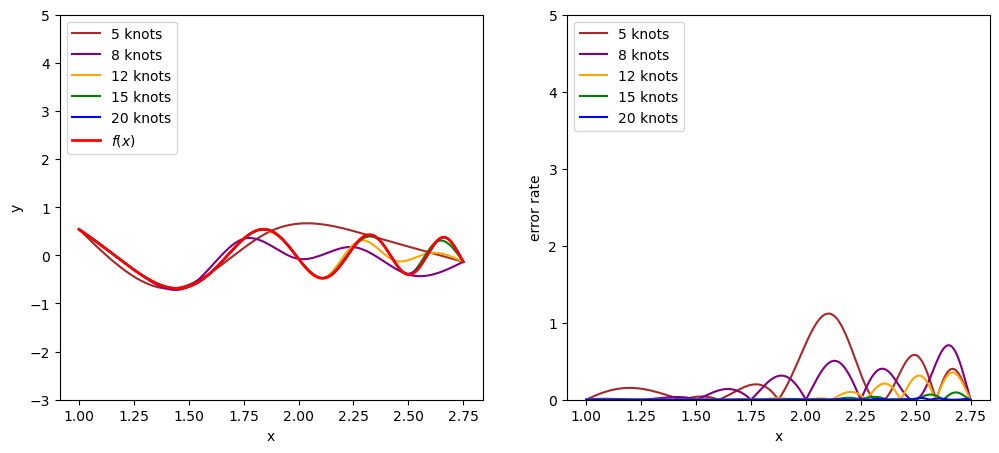

In [32]:
def g(x):
    return np.cos(x ** 3)/x


a, b = 1, 2.75 
k_list = [5, 8, 12, 15, 20]
colors = {
    5: 'brown',
    8: 'purple',
    12: 'orange',
    15: 'green',
    20: 'blue'
}

f_color = 'red'

xs = np.linspace(a, b, 250, endpoint=True)
ys = g(xs)


# Для глобальной интерполяции
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for k in k_list:
    x_arr = np.linspace(a, b, k, endpoint=True)
    y_arr = g(x_arr)
    global_interp = NewtonInterp1d(x_arr, y_arr)
    y_pred = global_interp(xs)
    axes[0].plot(xs, y_pred, c=colors[k],  label=f'{k} knots')
    axes[1].plot(xs, np.abs(y_pred - ys), c=colors[k], label=f'{k} knots')

axes[0].plot(xs, ys, ls='solid', linewidth=2, c=f_color, label='$f(x)$')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_ylim([-3, 5])
axes[0].legend(loc='upper left')

axes[1].set_xlabel('x')
axes[1].set_ylabel('error rate')
axes[1].set_ylim([0, 5])
axes[1].legend(loc='upper left')

plt.savefig(fname='plots/task4_global-interp.png')
plt.show()


# Для кубической интерполяции дефекта 1
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for k in k_list:
    x_arr = np.linspace(a, b, k, endpoint=True)
    y_arr = g(x_arr)
    cubic_interp = CubicSpline(x_arr, y_arr, bc_type='natural', extrapolate=False)
    y_pred = cubic_interp(xs)
    axes[0].plot(xs, y_pred, c=colors[k], label=f'{k} knots')
    axes[1].plot(xs, np.abs(y_pred - ys), c=colors[k], label=f'{k} knots')

axes[0].plot(xs, ys, ls='solid', linewidth=2, c=f_color, label='$f(x)$')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_ylim([-3, 5])
axes[0].legend(loc='upper left')

axes[1].set_xlabel('x')
axes[1].set_ylabel('error rate')
axes[1].set_ylim([0, 5])
axes[1].legend(loc='upper left')

plt.savefig(fname='plots/task4_cubic-interp.png')
plt.show()